In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [2]:
import logging
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from config import DATA_PATH
from network import GPCopulaNet
from utils import train_test_split, loss_GLL, transform, inv_transform_3D
from loader import TrainDataset

# Data Preprocessing

In [27]:
# load and preprocess the data
feature = pd.read_csv(DATA_PATH+'log_return.csv', index_col='Date')
df_tr, df_te = train_test_split(feature)

In [4]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, feature:pd.DataFrame, context_len:int=18):     
        self.raw    = feature.iloc[:-1]
        self.data   = np.array([self.raw[i-context_len:i].values for i in range(context_len,self.raw.shape[0])])
        self.labels = feature.shift(-1).iloc[context_len:-1].values
        self.train_len = self.data.shape[0]

        assert self.data.shape[0] == self.labels.shape[0], 'not equal'
        #logger.info(f'train_len: {self.train_len}')

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return self.data[index], self.labels[index] 


class EvalDataset(Dataset):
    def __init__(self, feature:pd.DataFrame, context_len:int=18):     
        self.raw    = feature.iloc[:-1]
        self.data   = np.array([self.raw[i-context_len:i].values for i in range(context_len,self.raw.shape[0])])
        self.labels = feature.shift(-1).iloc[context_len:-1].values
        self.train_len = self.data.shape[0]

        assert self.data.shape[0] == self.labels.shape[0], 'not equal'
        #logger.info(f'train_len: {self.train_len}')

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [25]:

SEQ_LENGTH  = 24
PRED_LENGTH = 4

net = GPCopulaNet(input_dim=1, hidden_dim=15, embed_dim=6, num_layers=2,
                num_assets=7, seq_length=24, pred_length=4, batch_size=1, rank_size=2)
optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
            


In [29]:
train(net, df_tr, optimizer, 5)

Validating with validation data...


tensor([103.5057], grad_fn=<DivBackward0>)

In [28]:
def train(
        model:nn.Module,
        data:pd.DataFrame, 
        optimizer:torch.optim.Optimizer, 
        #num_samples:int,
        num_epochs:int
    ) -> torch.Tensor:

    valid_split = int(data.shape[0] * 0.8)
    df_tr, df_vl = data.iloc[:valid_split], data.iloc[valid_split-SEQ_LENGTH:]
    dataset = TrainDataset(df_tr, context_len=SEQ_LENGTH)
    _, cdf_tr = transform(torch.Tensor(df_tr.values))
    loader = DataLoader(dataset, batch_size=1)

    # initialize weight and put the model on training mode.
    model.init_weight()
    model.train()

    for epoch in range(num_epochs):
        loss = torch.Tensor([0.0])

        for n_step, (train_batch, _) in enumerate(loader):
            train_batch, indice = train_batch.squeeze(0), torch.randperm(7)[:3]
            mu, cov = net(train_batch, indice)
            x, _ = transform(train_batch, cdf_tr)
            loss = loss + loss_GLL(x[:,indice], mu, cov)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and epoch != 0: 
            print(f'Epoch {epoch} Training MSE: {loss/(n_step+1)} \n')
        
        if epoch+1 == 11 or epoch+1 == num_epochs:
            print('Validating with validation data...')
    return loss/(n_step+1)

In [6]:
x_hat = net.predict(inputs[24:25],20)
z_hat = inv_transform_3D(x_hat, cdf)

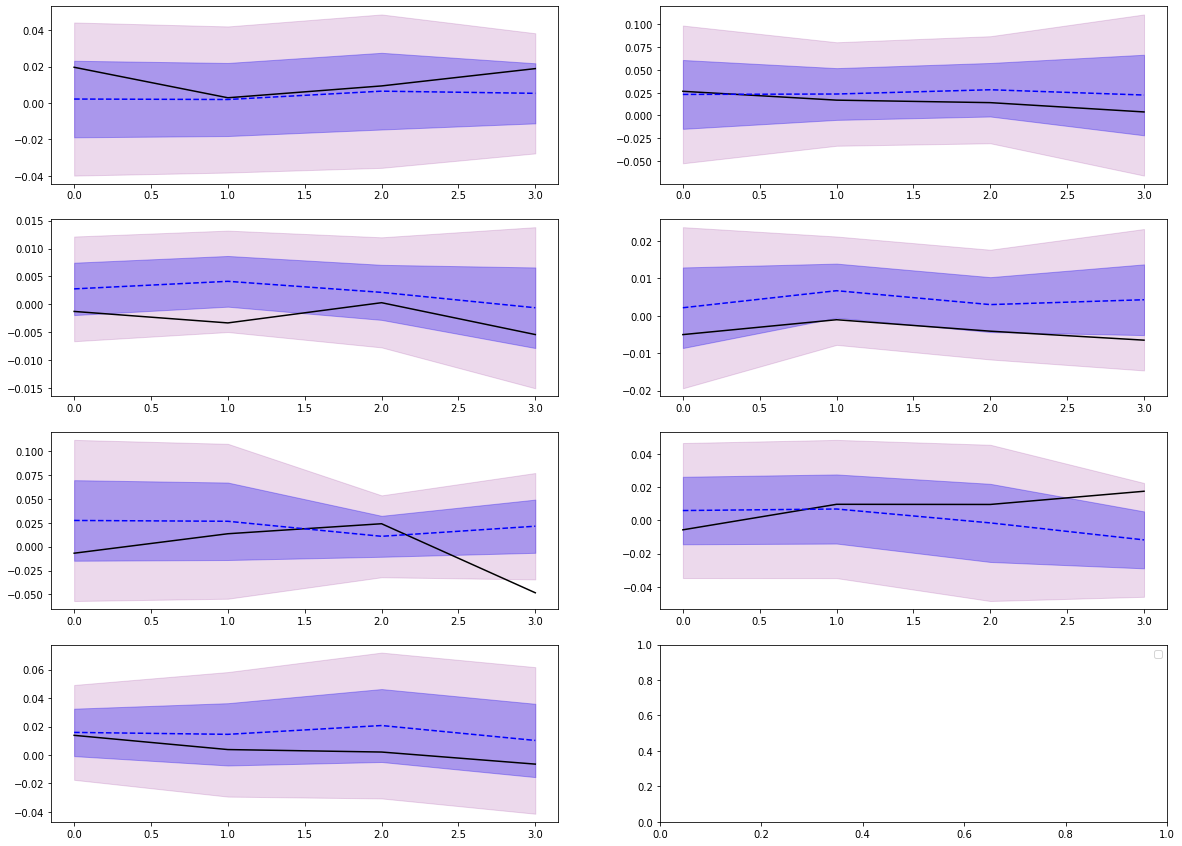

In [26]:
z_mean, z_std = z_hat.mean(axis=0), z_hat.std(axis=0)
plot_prediction(inputs[24:28], z_mean, z_std)